In [1]:
import numpy as np
from fish.ephys import ephys
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import collections
from skimage import io
from scipy.stats import zscore
from numpy import convolve
from scipy.signal import gaussian
import os
%matplotlib inline

In [2]:
def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    
def estimate_threshold(vec, window=180000, scaling=1.6):    
    """
    Return non-sliding windowed threshold of input ndarray vec
        
    vec : ndarray, input array to be thresholded
    window : step size / window length of the thresholding
    scaling : scaling factor applied to estimated spread of the noise distribution of vec, sets magnitude of threshold
    """
    from numpy import zeros, percentile, arange, median
    
    th = zeros(vec.shape)    
    for t in arange(0, vec.size-window, window):
        plr = arange(t, min(t+window, vec.size))
        sig = vec[plr]            
        med = median(sig)
        bottom = percentile(sig, .01)
        th[t:] = (med + scaling * (med - bottom))
    
    return th

def prepare_swim(swims):
    from numpy import percentile
    from fish.ephys.ephys import windowed_variance
    
    swim_flt = [windowed_variance(s, kern_mean=None, kern_var=None)[0] for s in swims]
    ts = (swim_flt[0] + swim_flt[1])
    ts = ts.clip(max = np.percentile(ts, 99.99))
    ts -= ts.min()
    ts /= ts.max()
    return ts

def trial_power(swim_signal, trial_signal):
    from fish.ephys.ephys import chop_trials
    from numpy import ceil, median, arange, array, where
    
    fs_ep = 6000
    laser = chop_trials(trial_signal > 0)[True]
    stim_len = ceil(median(laser[1] - laser[0]) / fs_ep)    
    rois = chop_trials(trial_signal)    
    conds = np.arange(1,len(rois))
    roi_keys = [x for x in rois]
    
    th = estimate_threshold(swim_signal)
    
    cond_swim_power = []
    wind_ep = arange(stim_len * fs_ep).astype('int')
    for cond in conds:        
        onsets = rois[cond][0]    
        inds = [array([wind_ep + (o - len(wind_ep)) for o in onsets])]
        inds.append(array([wind_ep + o for o in onsets]))
        inds.append(array([wind_ep + (o + len(wind_ep)) for o in onsets]))
    
        inds[-2] = inds[-2][where(inds[-2].max(1) < len(swim_signal))[0]]
        inds[-1] = inds[-1][where(inds[-1].max(1) < len(swim_signal))[0]]
    
        power = [(swim_signal[i] * (swim_signal[i] > th[i])).sum(1) for i in inds]        
        cond_swim_power.append(power)
        
    return cond_swim_power

In [3]:
base_dir = '/groups/ahrens/ahrenslab/davis/results/dmd-opto/data/'
proc_dir = '/groups/ahrens/ahrenslab/davis/results/dmd-opto/'
if not os.path.exists(proc_dir):
    os.makedirs(proc_dir)

In [4]:
from os.path import split, sep
fnames_ep = glob(base_dir + '*/*opto*.10chFlt')
fnames_ep.sort()

exp_dirs = [split(f)[0] + sep for f in fnames_ep]
for ind, f in enumerate(fnames_ep):
    print('{0} : {1}'.format(ind, f))

0 : /groups/ahrens/ahrenslab/davis/results/dmd-opto/data/20161031/5dpf_cy252xcy293_g1_f1_omr_opto_1.10chFlt
1 : /groups/ahrens/ahrenslab/davis/results/dmd-opto/data/20161031/5dpf_cy252xcy293_g1_f2_omr_opto_1.10chFlt
2 : /groups/ahrens/ahrenslab/davis/results/dmd-opto/data/20161101/6dpf_cy252xcy293_g1_f1_omr_opto_1.10chFlt
3 : /groups/ahrens/ahrenslab/davis/results/dmd-opto/data/20161101/6dpf_cy252xcy293_g1_f2_omr_opto_1.10chFlt


In [5]:
# in one recording I got the order of the rois wrong, so I will correct it manually here
flipped = '/groups/ahrens/ahrenslab/davis/results/dmd-opto/data/20161031/5dpf_cy252xcy293_g1_f1_omr_opto_1.10chFlt'
roi_orders = []
for ind, fn in enumerate(fnames_ep):
    if fn == flipped:
        roi_orders.append([1,0,2,3])
    else:
        roi_orders.append([0,1,2,3])

In [6]:
exps = np.arange(len(fnames_ep))
exp_names = [fnames_ep[e].split('/')[-1].split('.')[0] for e in exps]

fnames_roi = []
for ind, expn in enumerate(exp_names):
    fnames_roi.append(glob(exp_dirs[ind] + expn + '*_ROI_*.tif'))
[f.sort() for f in fnames_roi]

fnames_roi = [np.array(fn)[roi_orders[ind]] for ind, fn in enumerate(fnames_roi)]

epochs = ['Pre', 'Stim', 'Post']

ims_roi = []
for froi in fnames_roi:
    ims_roi.append([plt.imread(f) for f in froi])

    
dats = [ephys.load(fnames_ep[e]) for e in exps]
ims_anat = [plt.imread(fnames_ep[e].split('.')[0] + '.tif') for e in exps]

swims = [prepare_swim(d[0:2]) for d in dats]
cond_swim_powers = [np.array(trial_power(swims[ind], d[3]))[roi_orders[ind]] for ind, d in enumerate(dats)]

# trim each set of swim powers so that we have pre, stim, post for all conditions
for fish in cond_swim_powers:
    for roi in fish:        
        mx_index = min(map(len, roi))
        for ind in range(len(roi)):
            roi[ind] = roi[ind][:mx_index]            

## Get power before, during, after laser stim

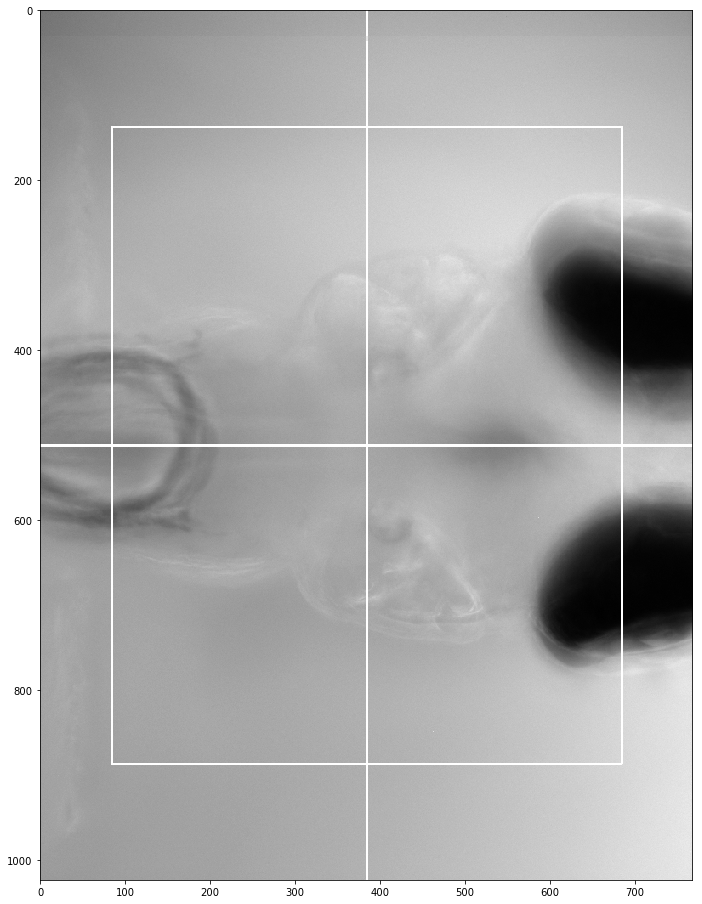

In [7]:
tmp = np.zeros(ims_anat[0].shape)

for im in ims_anat:
    tmp += im.astype('float32')
plt.figure(1,(16,16))
plt.imshow(tmp, cmap='gray')

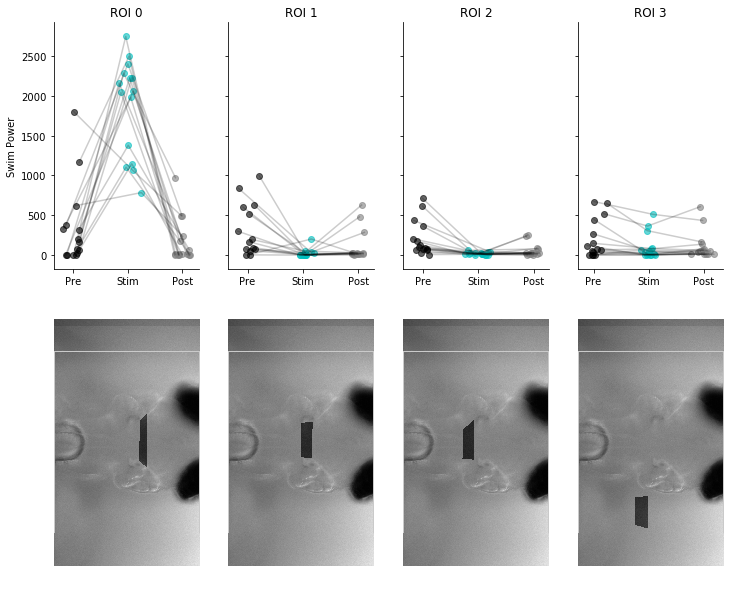

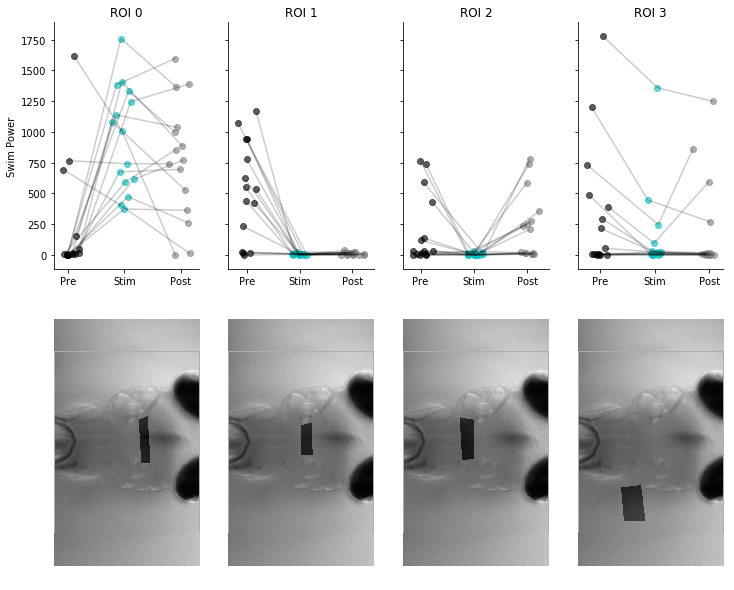

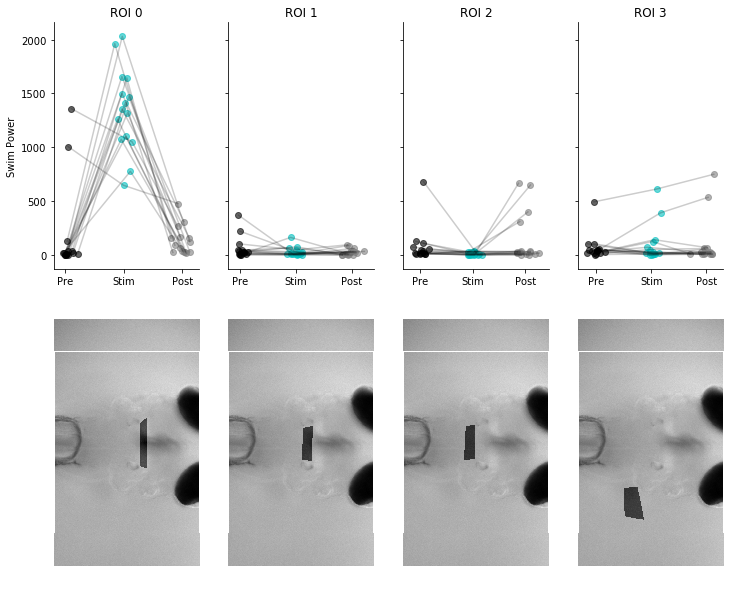

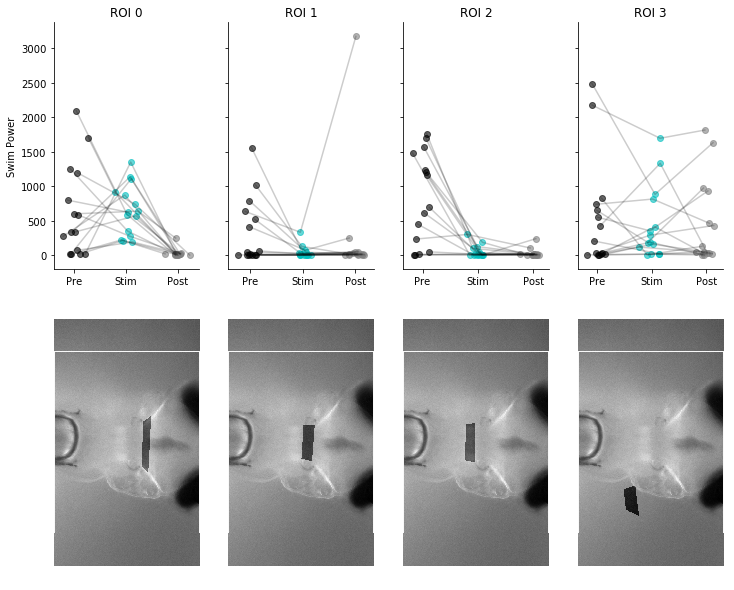

In [8]:
for cur_exp in range(len(cond_swim_powers)):

    powers = cond_swim_powers[cur_exp]
    std = .1
    fig, axs = plt.subplots(ncols=len(powers),nrows=2, figsize=(3 * len(powers), 10), sharey='row')
    axs[0][0].set_ylabel('Swim Power')
    colors = ['k','c','gray']

    for ind_c, cond in enumerate(powers):
    
        # truncate to minimum number of trials
        trunc = np.zeros([len(cond), min(map(len, cond))])
        for ind_t, c in enumerate(cond):
            trunc[ind_t] = c[:min(map(len, cond))]
    
        jitter = std * np.random.randn(*trunc.shape)    
    
        for ind_j, j in enumerate(jitter):
            j += ind_j
        
        cur_ax = axs[0][ind_c]
        cur_ax.plot(jitter, trunc, 'k', alpha = .2)    
        [cur_ax.scatter(jitter[ind_t][:len(vec)], vec, color = colors[ind_t], alpha = .6 ) for ind_t, vec in enumerate(trunc)];    
    
        cur_ax.set_xticks([0, 1, 2])
        cur_ax.set_xticklabels(epochs)
        cur_ax.set_title('ROI {0}'.format(ind_c))
        axs_format(cur_ax)
    
        im_ax = axs[1][ind_c]
        im_ax.imshow(ims_roi[cur_exp][ind_c][:,:,0] * 70 + ims_anat[cur_exp], cmap='gray')
        im_ax.axis('off')

#plt.savefig(proc_dir + exp_name + '_trial_summary.pdf')

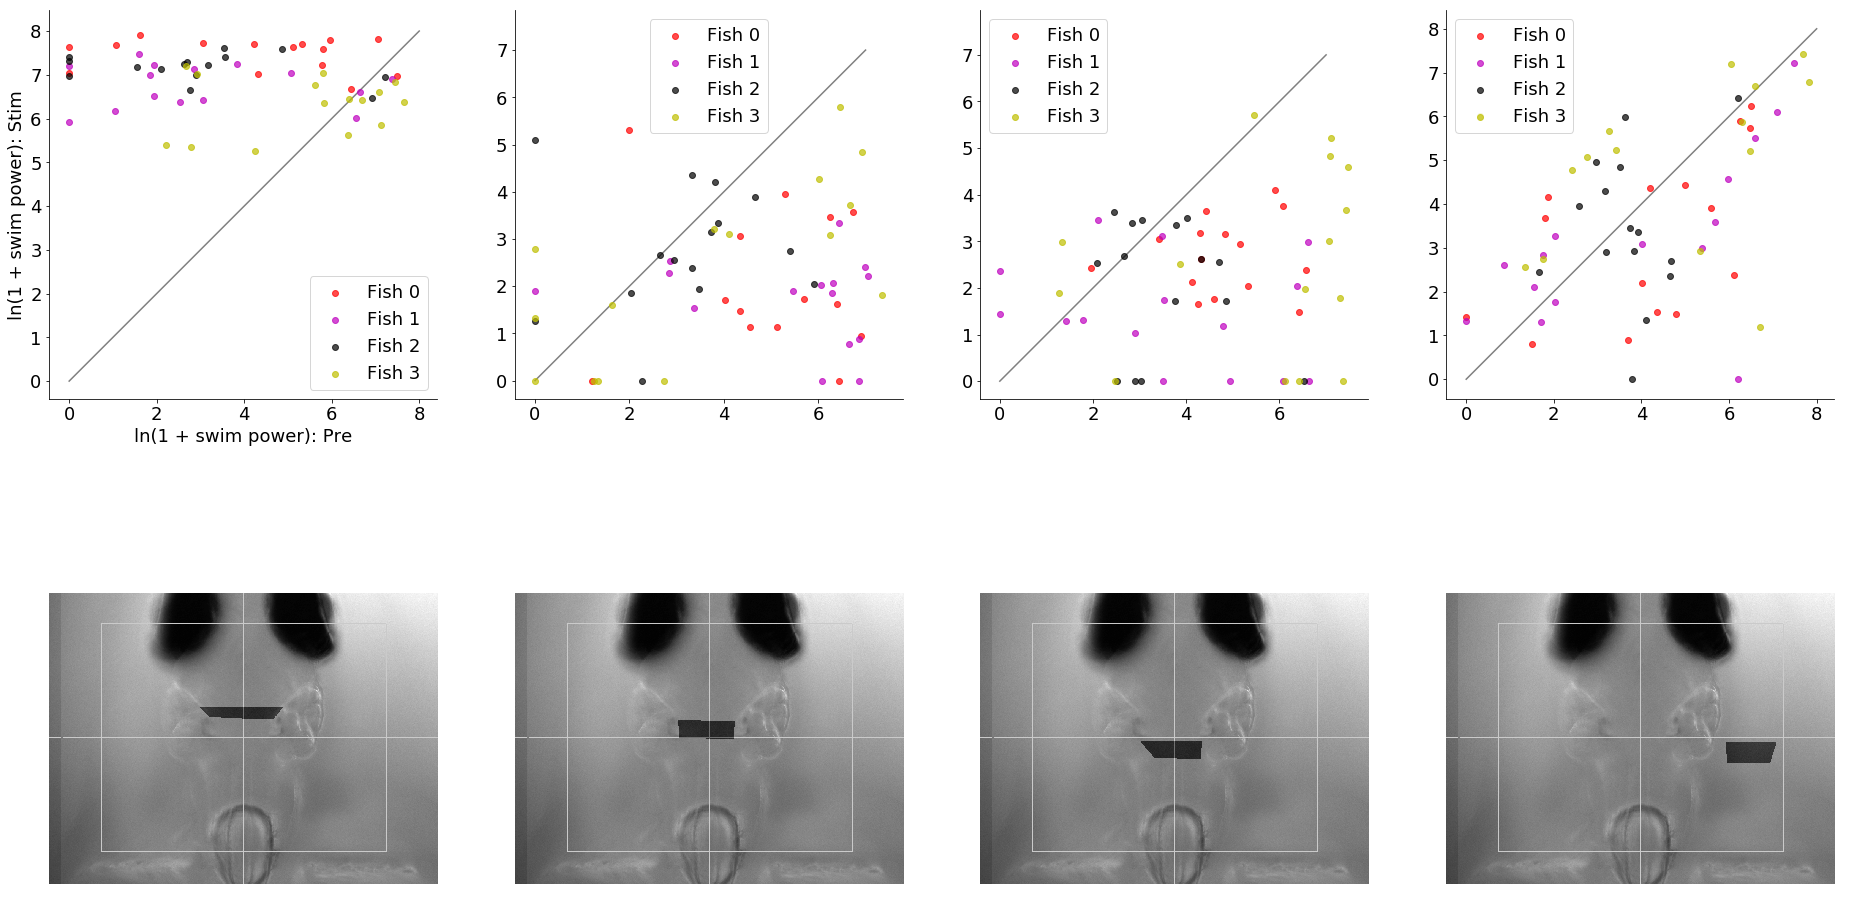

In [16]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
compare = [0,1]
colors = ['r','m','k','y']
gridspec = {'height_ratios': [2,1]}
fig, axs = plt.subplots(ncols=len(roi_orders[0]), nrows=2, figsize=(32,18), gridspec_kw=gridspec)

for roi in range(len(roi_orders[0])):
    ax = axs[0][roi]
    for fish, power in enumerate(cond_swim_powers):
        ax.scatter(np.log(1 + power[roi][compare[0]]), np.log(1 + power[roi][compare[1]]), label='Fish {0}'.format(fish), alpha = .7, color=colors[fish])        
    null_line = np.arange(0, max(*ax.get_ylim(), *ax.get_xlim()))
    ax.legend()
    ax.plot(null_line, null_line, zorder=0, color='gray')
    ax.axis('square')
    axs_format(ax)
    axs[1][roi].imshow((ims_roi[0][roi][:,:,0] * 70 + ims_anat[0]).T, cmap='gray', origin='lower')
    axs[1][roi].axis('off')

axs[0][0].set_xlabel('ln(1 + swim power): {0}'.format(epochs[compare[0]]) )
axs[0][0].set_ylabel('ln(1 + swim power): {0}'.format(epochs[compare[1]]) )
    